## E2E机器学习例子 - 房价预测

### 了解项目目的和获取数据

In [1]:
# 参考: Aurélien Géron, Hands-On Machine Learning with Scikit-Learn and TensorFlow, 2017

import os
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 定义数据文件路径
HOUSING_PATH = r".\datasets\housing"
HOUSING_FILE = "housing.tgz"

# 解压数据文件到指定路径
def fetch_housing_data(housing_path=HOUSING_PATH, housing_file=HOUSING_FILE):
    tgz_file = os.path.join(housing_path, housing_file)
    housing_tgz = tarfile.open(tgz_file)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# 读入数据为Dataframe格式
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [2]:
fetch_housing_data()
housing = load_housing_data()
# 获取数据总体信息
housing.info()
# 显示数字属性的信息汇总
housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,NaN,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,NaN,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,NaN,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A351908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000ABE3668>]], dtype=object)

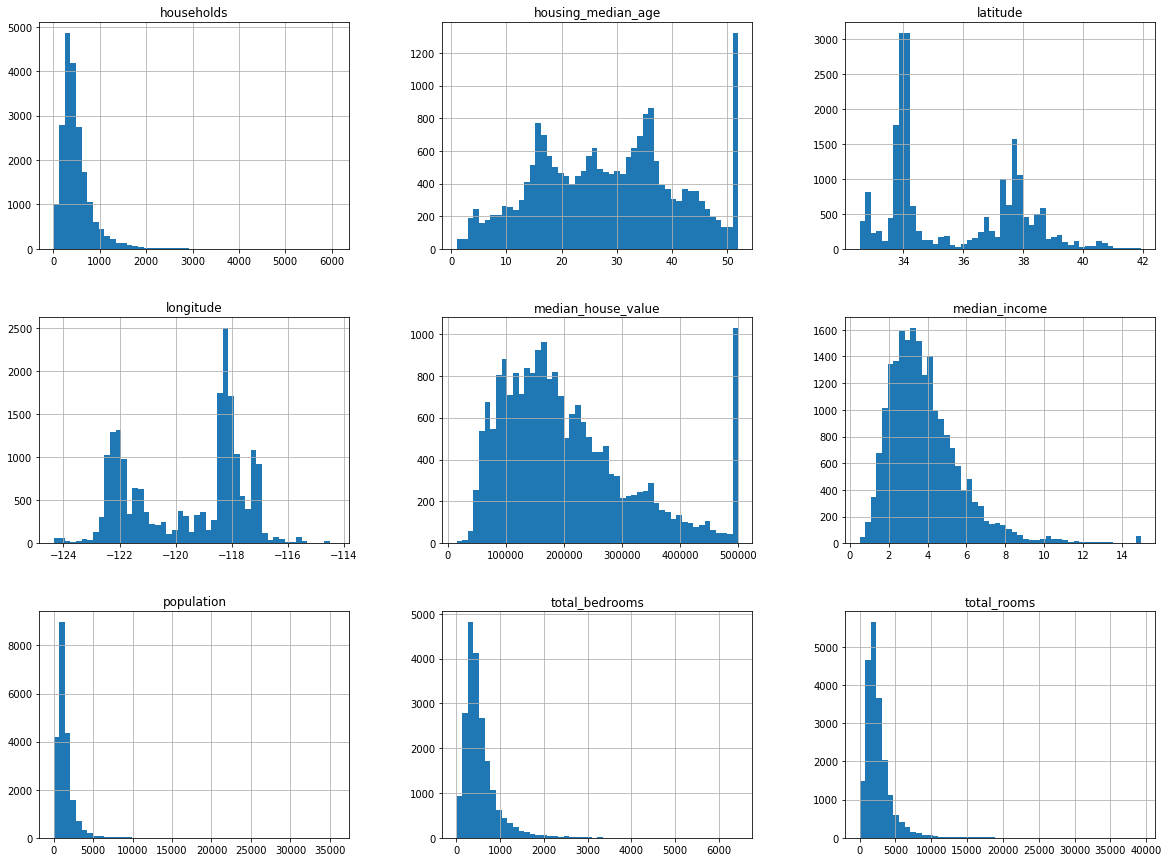

In [3]:
# 数值属性直方图，从图中可以看到income/housing age/house value上限可能都做了限制。比如housing age大于50的都表示为50
housing.hist(bins=50, figsize=(20,15))

In [4]:
# 将数据随机划分为训练数据和测试数据，80%数据作为训练数据，20%数据作为测试数据
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing['income_cat'] = np.ceil(housing['median_income']/1.5 )
# 如果housing['income_cat']元素值小于5，则返回原值，否则返回5
housing['income_cat'].where(housing['income_cat']<5, 5.0, inplace=True)

# 分层ShuffleSplit交叉验证器
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

### 对数据进一步挖掘和可视化

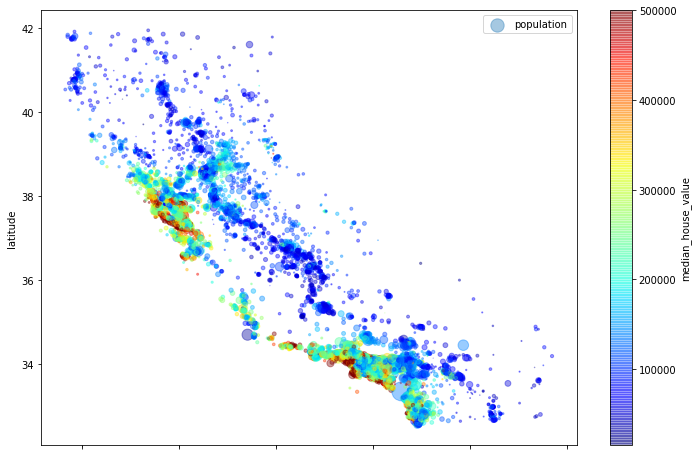

In [5]:
housing= strat_train_set.copy()
# 图像显示房价与地理位置密切相关，通过设置alpha值可以展示房子分布，颜色越深表示房子密度越大，右边的色图颜色表示房价的高低
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
             s=housing['population']/100, label='population',
             c='median_house_value', cmap=plt.get_cmap('jet'), 
             figsize=(12,8))

In [6]:
# 寻找不同feature之间相关性
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

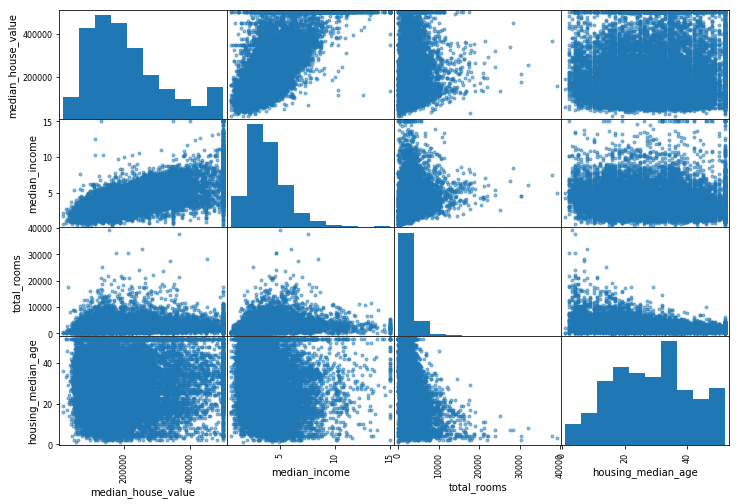

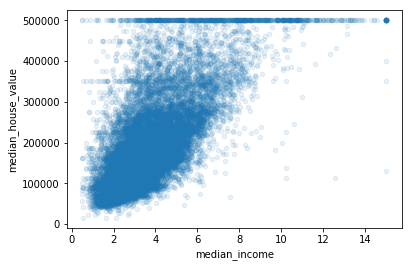

In [7]:
from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))

housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [8]:
# 探索发现和房价更相关的属性，比如bedrooms_per_room
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### 为机器学习输入准备数据

In [9]:
# 将数据和标签分开
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [10]:
# 使用Imputer类处理缺失值
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
# 对所有数值型feature进行缺失值处理
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
print(imputer.statistics_)
print(housing_num.columns)
print(housing_num.median().values)

x = imputer.transform(housing_num)
# 把处理后的数据转换为dataframe
housing_tr = pd.DataFrame(x, columns=housing_num.columns)
housing_tr.head()

[ -118.51      34.26      29.      2119.5      433.      1164.       408.
     3.5409]
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')
[ -118.51      34.26      29.      2119.5      433.      1164.       408.
     3.5409]


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


Fit操作是从数据中找出用于数据转换的参数，而transform则是将这些参数应用于数。
比如之前使用imputer，fit是为了获取数据的median的值，而transform则是将median值用于替换缺失值
fit和transform可以使用fit_transform合并在一起完成fit和transform功能

In [11]:
# 将文字分类feature转换为数字feature
from sklearn.preprocessing import LabelBinarizer

housing_cat = housing["ocean_proximity"]
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot.shape

(16512, 5)

In [12]:
# 根据需要定制自己的transformer
from sklearn.base import BaseEstimator, TransformerMixin

room_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, room_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, room_ix]
            # numpy.c_: Translates slice objects to concatenation along the second axis.
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing.values)
print(housing.values.shape)
print(housing_extra_attribs.shape)

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names].values

(16512, 9)
(16512, 12)


Feature scaling (数据规范化/特征缩放) 是数据挖掘或机器学习常用到的步骤，这个步骤有时对算法的效率和准确率都会产生巨大的影响。NG的ML课程中有具体例子可参考。
常用的feature scaling方法有：min-max scaling and standardization.
min-max scaling: 数据值会转换到0-1之间的取值，有些机器学习方法需要输入数据是0-1之间的数值，比如一些神经网络
standardization: 数据每个特征的值减去均值，然后除以方差从而得到单位方差分布，这种方法收到异常值的影响比min-max scaling方法小

In [13]:
# 机器学习的数据输入往往需要很多数据转换步骤，Sklearn提供了pipeline类来帮助完成这些转换
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_addr', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])
# 使用FeatureUnion组合不同的pipeline
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

### 选择和训练模型

In [14]:
# 线性模型
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:', lin_reg.predict(some_data_prepared))
print('Labels:\t', list(some_labels))

# 测量误差
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:	 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


68628.198198489219

In [15]:
# 决策树模型
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

交叉验证：是用来验证分类器的性能一种统计分析方法，基本思想是把在某种意义下将原始数据(dataset)进行分组，一部分做为训练集(train set)，另一部分做为验证集(validation set)，首先用训练集对分类器进行训练，在利用验证集来测试训练得到的模型(model)，以此来做为评价分类器的性能指标。  
K-fold交叉验证：将原始数据分成K组(一般是均分)，将每个子集数据分别做一次验证集，其余的K-1组子集数据作为训练集，用这K个模型最终的验证集的分类准确率的平均数作为此分类器的性能指标，这种方法可以有效的避免过学习以及欠学习状态的发生。  
Leave-One-Out交叉验证：如果设原始数据有N个数据，每个数据单独作为验证集，其余的N-1个数据作为训练集，所以会得到N个模型，用这N个模型最终的验证集的分类准确率的平均数作为此分类器的性能指标。由于每一回合中几乎所有的数据皆用于训练模型，因此最接近原始样本的分布,这样评估所得的结果比较可靠，同时受随机因素影响小，但是计算成本高。

In [16]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# 决策树
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
# 交叉验证期望unility function（越大越好）而不是cost function（越小越好），所以scoring与MSE相反，计算rmse需要对score取负
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

# 线性模型
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

#随机森林
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 68669.34697403  66672.61845027  70599.0528368   68769.38824843
  72524.55098199  76306.2338029   70082.24950543  70654.84090956
  75248.71489559  70620.14779466]
Mean: 71014.71444
Standard deviation: 2809.44899346
Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018
22243.4861005
Scores: [ 52011.87712     50032.57278696  53238.32370024  56291.79647426
  52359.75090271  56464.24684495  52033.54814999  50793.39610204
  55328.75629987  53273.53583776]
Mean: 53182.7804219
Standard deviation: 2098.87182285


###  调整模型

In [17]:
# GridSearchCV: 输入想要试验的超参和对应的取值，GridSearchCV会使用交叉验证对超参的各种组合进行估计
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

{'n_estimators': 30, 'max_features': 6}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
63901.2180448 {'n_estimators': 3, 'max_features': 2}
55381.3080967 {'n_estimators': 10, 'max_features': 2}
52858.2409881 {'n_estimators': 30, 'max_features': 2}
59979.1696989 {'n_estimators': 3, 'max_features': 4}
53183.5588382 {'n_estimators': 10, 'max_features': 4}
50465.5504746 {'n_estimators': 30, 'max_features': 4}
60798.7473569 {'n_estimators': 3, 'max_features': 6}
52194.2270497 {'n_estimators': 10, 'max_features': 6}
49886.1538488 {'n_estimators': 30, 'max_features': 6}
58847.1707959 {'n_estimators': 3, 'max_features': 8}
52339.032458 {'n_estimators': 10, 'max_features': 8}
50128.1394127 {'n_estimators':

In [18]:
# 分析最好的模型和它的偏差
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

extra_attribs = ['room_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[  7.13458646e-02   6.72357926e-02   4.19940602e-02   1.78728194e-02
   1.68186733e-02   1.74445088e-02   1.63824593e-02   3.57001503e-01
   5.66404155e-02   1.09152869e-01   5.77634615e-02   5.73183584e-03
   1.58019385e-01   1.14366567e-04   2.52841117e-03   3.95357440e-03]


[(0.35700150292256894, 'median_income'),
 (0.15801938531255447, 'INLAND'),
 (0.1091528685260556, 'pop_per_hhold'),
 (0.071345864647439736, 'longitude'),
 (0.067235792597911737, 'latitude'),
 (0.05776346151461078, 'bedrooms_per_room'),
 (0.056640415511923607, 'room_per_hhold'),
 (0.041994060183606866, 'housing_median_age'),
 (0.017872819416557478, 'total_rooms'),
 (0.017444508784481012, 'population'),
 (0.016818673323405038, 'total_bedrooms'),
 (0.016382459279639043, 'households'),
 (0.0057318358398902088, '<1H OCEAN'),
 (0.0039535743999075217, 'NEAR OCEAN'),
 (0.0025284111724051287, 'NEAR BAY'),
 (0.00011436656704277731, 'ISLAND')]

In [19]:
# 使用测试集评价模型
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47876.102479894595

### 发布、监测和维护模型

In [20]:
from sklearn.externals import joblib

joblib.dump(final_model, 'housing_random_forest_model.pkl')

['housing_random_forest_model.pkl']

In [21]:
final_model_loaded = joblib.load("housing_random_forest_model.pkl")
final_model_loaded

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)